# Model Robustness

**Objectives**
- Load the Model(s)
- Run predictions on the model using the Holdout/Test Datasplit (better if the malicious samples are verified for malware types)
- Record instances where the model failed to predict correctly
- Record the performance of the models (e.g., Accuracy, Precision, Recall, ROC-AUC, etc.)

In [51]:
import pandas as pd
import numpy as np

import lightgbm as lgbm
import catboost as catb

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, average_precision_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay

from joblib import load
import warnings
warnings.filterwarnings("ignore")

## 1. Determine the Model Performance in each of the GBDT Models and each of its two behavior-types.

`How does the model perform using 'real-world' data (i.e., Test/Holdout Split)?`

Run other metrics as well as you see fit that are not found in the classification_report and Confusion Matrix.

- Label column is `0/'malicious'`
- Feature column is `[:, 1:101]`

### 1.1 Defining a helper function for evaluation


In [52]:
def evaluate(model, test_set, y_actual):
    y_pred = model.predict(test_set)
    cm = confusion_matrix(y_actual, y_pred)
    print(classification_report(y_actual, y_pred, digits=4))
    print(f"AUC-ROC Score: {roc_auc_score(y_actual, y_pred):.4f}")
    print("ROC Curve & Confusion matrix:")
    RocCurveDisplay.from_predictions(y_actual, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    #print(classification_report(y_actual, y_pred, digits=4))
    

### 1.2 LightGBM

In [53]:
DF_LGBM_TB = pd.read_csv('Dataset/LGBM_TB_Test.csv', low_memory=False) #<== Point these to the proper Test/Holdout datasets.
DF_LGBM_IB = pd.read_csv('Dataset/LGBM_IB_Test.csv', low_memory=False)

display(DF_LGBM_TB.head())
print(DF_LGBM_TB['type'].unique())
display(DF_LGBM_IB.head())
print(DF_LGBM_IB['type'].unique())

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,208,172,240,117,240,262,112,123,65,...,274,215,274,215,274,215,274,215,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,215,274,158,215,274,158,215,172,117,...,15,240,117,240,117,240,117,172,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,82,240,117,240,117,240,117,240,117,...,208,93,208,16,31,215,108,208,24dd4677c14eb5828bda78749fded6b8,pua
4,1,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,cc5d38cb80faaf60d8efabecdc04f832,trojan


['trojan' 'pua' 'adware' 'downloader' 'hacktool' 'benign' 'worm'
 'ransomware' 'miner' 'virus' 'spyware']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,208,172,240,117,262,112,123,65,274,...,307,307,307,307,307,307,307,307,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,215,274,158,172,117,198,208,260,257,...,307,307,307,307,307,307,307,307,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,82,240,117,93,16,228,208,198,86,...,307,307,307,307,307,307,307,307,24dd4677c14eb5828bda78749fded6b8,pua
4,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,cc5d38cb80faaf60d8efabecdc04f832,trojan


['trojan' 'pua' 'adware' 'downloader' 'hacktool' 'benign' 'worm'
 'ransomware' 'miner' 'virus' 'spyware']


In [54]:
# Load trained LightGBM model files
default_tb = load('Models/LGBM/Default/RYZEN3b_LGBM_TB.model') # <== Point these to the respective .model files
default_ib = load('Models/LGBM/Default/RYZEN3b_LGBM_IB.model')
tuned_tb = load('Models/LGBM/Tuned/TUNED_Manual_RYZEN3b_LGBM_TB.model')
tuned_ib = load('Models/LGBM/Tuned/TUNED_Manual_RYZEN3b_LGBM_IB.model')

1. Default LGBM TB

              precision    recall  f1-score   support

           0     0.9851    0.5789    0.7293       114
           1     0.9882    0.9998    0.9939      4010

    accuracy                         0.9881      4124
   macro avg     0.9866    0.7893    0.8616      4124
weighted avg     0.9881    0.9881    0.9866      4124

AUC-ROC Score: 0.7893
ROC Curve & Confusion matrix:


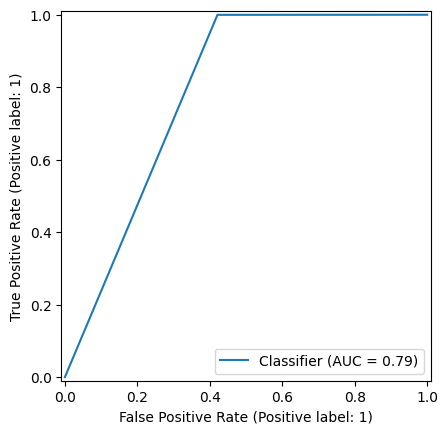

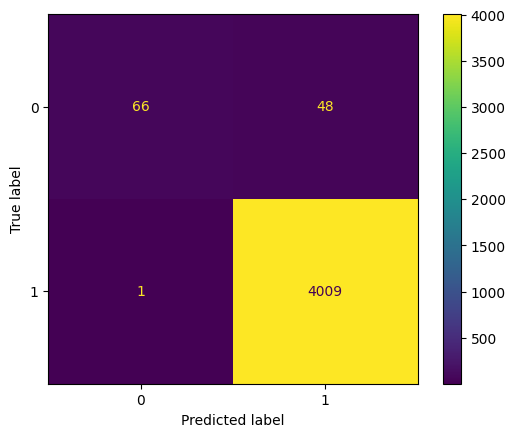

In [55]:
print("1. Default LGBM TB\n")
evaluate(default_tb, DF_LGBM_TB.iloc[:,1:101], DF_LGBM_TB.iloc[:,0])

2. Default LGBM IB

              precision    recall  f1-score   support

           0     0.9067    0.5965    0.7196       114
           1     0.9886    0.9983    0.9934      4010

    accuracy                         0.9871      4124
   macro avg     0.9477    0.7974    0.8565      4124
weighted avg     0.9864    0.9871    0.9859      4124

AUC-ROC Score: 0.7974
ROC Curve & Confusion matrix:


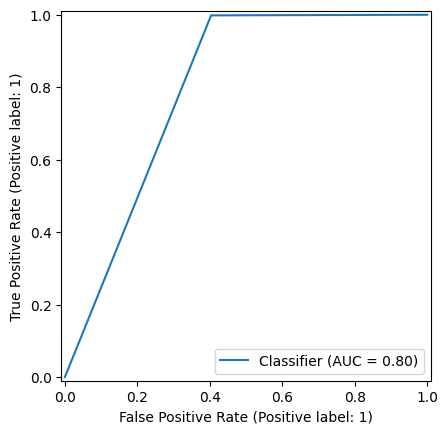

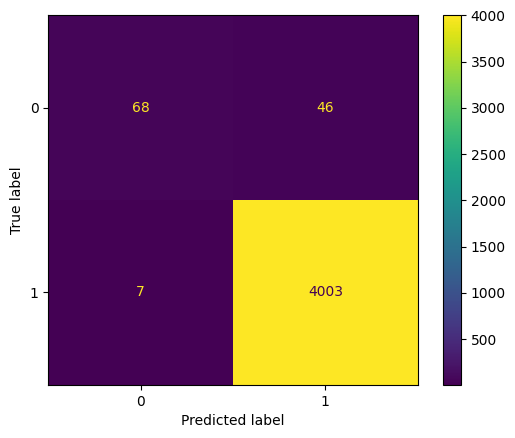

In [56]:
print("2. Default LGBM IB\n")
evaluate(default_ib, DF_LGBM_IB.iloc[:,1:101], DF_LGBM_IB.iloc[:,0])

3. Tuned LGBM TB

              precision    recall  f1-score   support

           0     0.9855    0.5965    0.7432       114
           1     0.9887    0.9998    0.9942      4010

    accuracy                         0.9886      4124
   macro avg     0.9871    0.7981    0.8687      4124
weighted avg     0.9886    0.9886    0.9872      4124

AUC-ROC Score: 0.7981
ROC Curve & Confusion matrix:


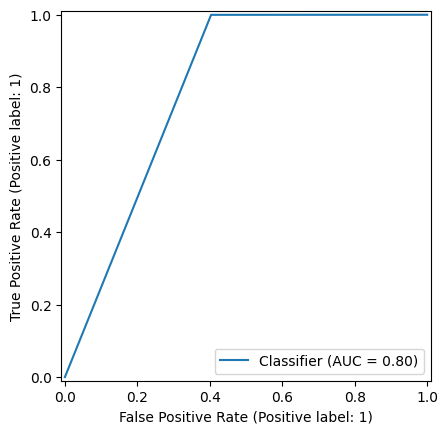

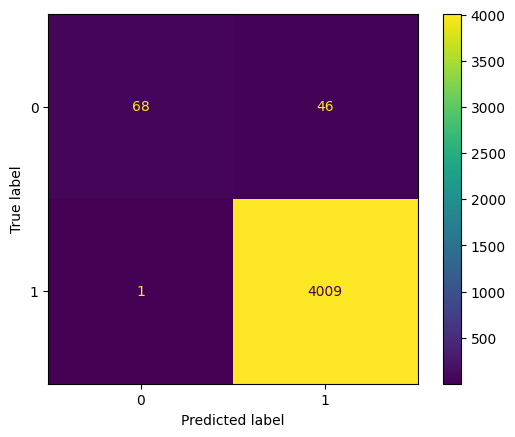

In [57]:
print("3. Tuned LGBM TB\n")
evaluate(tuned_tb, DF_LGBM_TB.iloc[:,1:101], DF_LGBM_TB.iloc[:,0])

4. Tuned LGBM IB

              precision    recall  f1-score   support

           0     0.9506    0.6754    0.7897       114
           1     0.9908    0.9990    0.9949      4010

    accuracy                         0.9901      4124
   macro avg     0.9707    0.8372    0.8923      4124
weighted avg     0.9897    0.9901    0.9892      4124

AUC-ROC Score: 0.8372
ROC Curve & Confusion matrix:


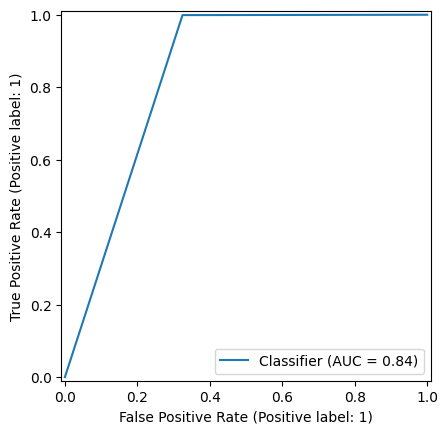

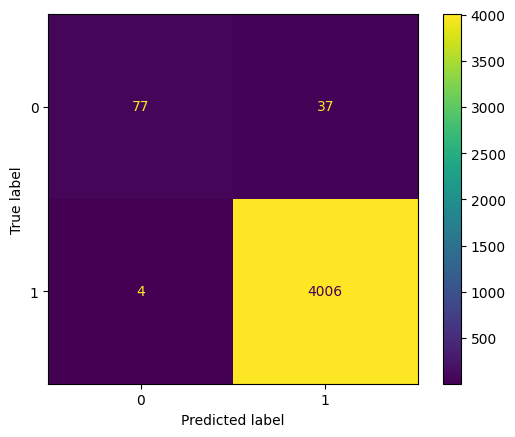

In [58]:
print("4. Tuned LGBM IB\n")
evaluate(tuned_ib, DF_LGBM_IB.iloc[:,1:101], DF_LGBM_IB.iloc[:,0])

### 1.3 CatBoost

In [59]:
DF_CATB_TB = pd.read_csv('Dataset/CATB_TB_Test.csv', low_memory=False) #<== Point these to the proper Test/Holdout datasets.
DF_CATB_IB = pd.read_csv('Dataset/CATB_IB_Test.csv', low_memory=False)

DF_CATB_IB.iloc[:,1:101] = DF_CATB_IB.iloc[:,1:101].astype('str')
DF_CATB_IB.replace("nan", "NaN", inplace=True)

#DF_CATB_TB = DF_CATB_TB[DF_CATB_TB['Type 1'] != '_']
#DF_CATB_IB = DF_CATB_IB[DF_CATB_IB['Type 1'] != '_']

display(DF_CATB_TB.head())
print(DF_CATB_TB['type'].unique())
display(DF_CATB_IB.head())
print(DF_CATB_IB['type'].unique())

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,NtAllocateVirtualMemory,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,NtQuerySystemInformation,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,...,NtOpenKey,NtClose,NtOpenKey,NtClose,NtOpenKey,NtClose,NtOpenKey,NtClose,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtAllocateVirtualMemory,GetFileType,NtAllocateVirtualMemory,SetUnhandledExceptionFilter,CoInitializeEx,NtClose,WSAStartup,NtAllocateVirtualMemory,24dd4677c14eb5828bda78749fded6b8,pua
4,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,cc5d38cb80faaf60d8efabecdc04f832,trojan


['trojan' 'pua' 'adware' 'downloader' 'hacktool' 'benign' 'worm'
 'ransomware' 'miner' 'virus' 'spyware']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,NtAllocateVirtualMemory,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtQuerySystemInformation,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,NtOpenKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,GetFileType,SetUnhandledExceptionFilter,NtProtectVirtualMemory,NtAllocateVirtualMemory,GetSystemInfo,NtCreateMutant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24dd4677c14eb5828bda78749fded6b8,pua
4,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cc5d38cb80faaf60d8efabecdc04f832,trojan


['trojan' 'pua' 'adware' 'downloader' 'hacktool' 'benign' 'worm'
 'ransomware' 'miner' 'virus' 'spyware']


In [60]:
# Load trained CatBoost model files (CatBoost requires instantiation before being able to load a trianed model file).
default_tb = catb.CatBoostClassifier()
default_ib = catb.CatBoostClassifier()
tuned_tb = catb.CatBoostClassifier()
tuned_ib = catb.CatBoostClassifier()
default_tb = default_tb.load_model("Models/CATB/Default/RYZEN2b_CATB_TB.model", format='json') # <== Point these to the respective .model files
default_ib = default_ib.load_model("Models/CATB/Default/RYZEN2b_CATB_IB.model", format='json')
tuned_tb = tuned_tb.load_model("Models/CATB/Tuned/TUNED_RYZEN2b_CATB_TB.model", format='json')
tuned_ib = tuned_ib.load_model("Models/CATB/Tuned/TUNED_RYZEN2b_CATB_IB.model", format='json')

1. Default CatBoost TB

              precision    recall  f1-score   support

           0     0.9571    0.5877    0.7283       114
           1     0.9884    0.9993    0.9938      4010

    accuracy                         0.9879      4124
   macro avg     0.9728    0.7935    0.8610      4124
weighted avg     0.9875    0.9879    0.9865      4124

AUC-ROC Score: 0.7935
ROC Curve & Confusion matrix:


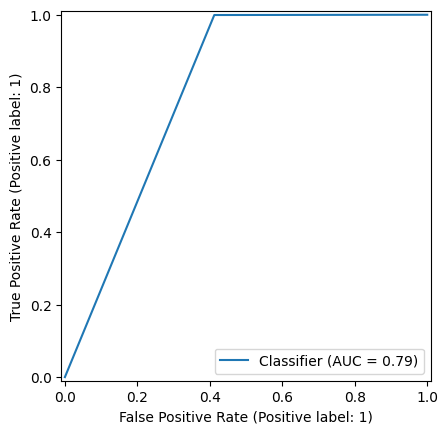

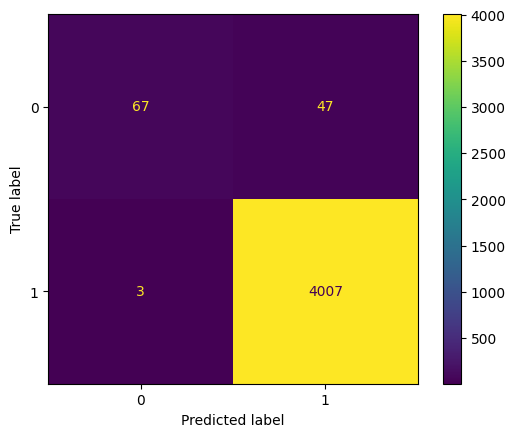

In [61]:
print("1. Default CatBoost TB\n")
evaluate(default_tb, DF_CATB_TB.iloc[:,1:101], DF_CATB_TB.iloc[:,0])

2. Default CatBoost IB

              precision    recall  f1-score   support

           0     0.9351    0.6316    0.7539       114
           1     0.9896    0.9988    0.9942      4010

    accuracy                         0.9886      4124
   macro avg     0.9623    0.8152    0.8740      4124
weighted avg     0.9881    0.9886    0.9875      4124

AUC-ROC Score: 0.8152
ROC Curve & Confusion matrix:


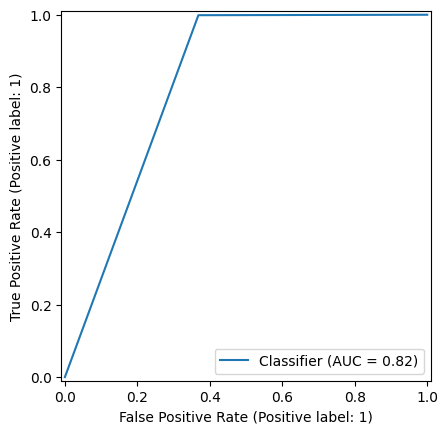

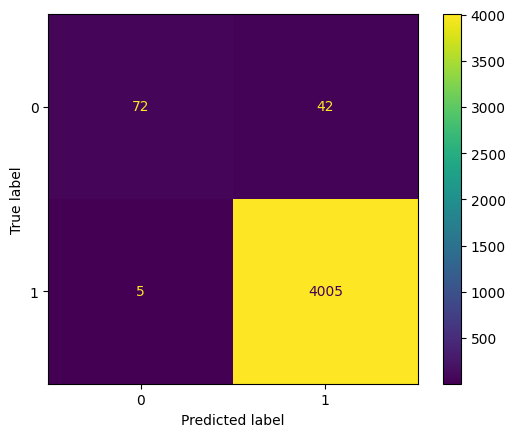

In [62]:
print("2. Default CatBoost IB\n")
evaluate(default_ib, DF_CATB_IB.iloc[:,1:101], DF_CATB_IB.iloc[:,0])

3. Tuned CatBoost TB

              precision    recall  f1-score   support

           0     0.9315    0.5965    0.7273       114
           1     0.9886    0.9988    0.9937      4010

    accuracy                         0.9876      4124
   macro avg     0.9601    0.7976    0.8605      4124
weighted avg     0.9871    0.9876    0.9863      4124

AUC-ROC Score: 0.7976
ROC Curve & Confusion matrix:


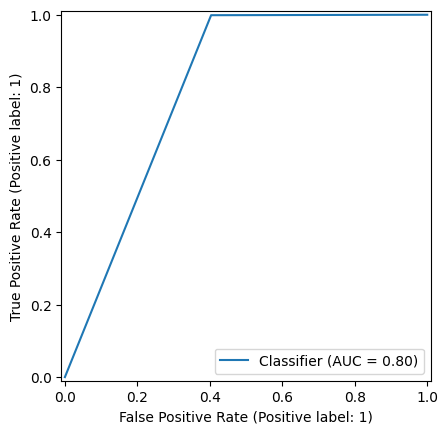

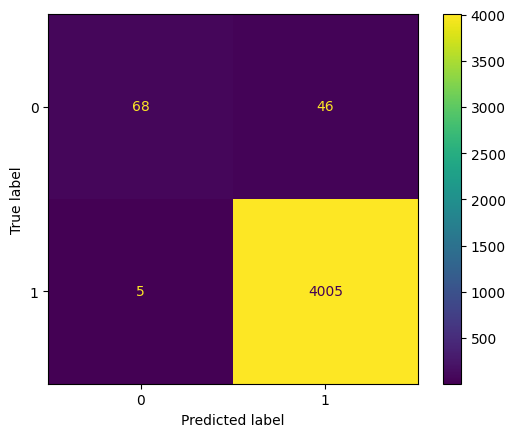

In [63]:
print("3. Tuned CatBoost TB\n")
evaluate(tuned_tb, DF_CATB_TB.iloc[:,1:101], DF_CATB_TB.iloc[:,0])

4. Tuned CatBoost IB

              precision    recall  f1-score   support

           0     0.9167    0.5789    0.7097       114
           1     0.9882    0.9985    0.9933      4010

    accuracy                         0.9869      4124
   macro avg     0.9524    0.7887    0.8515      4124
weighted avg     0.9862    0.9869    0.9855      4124

AUC-ROC Score: 0.7887
ROC Curve & Confusion matrix:


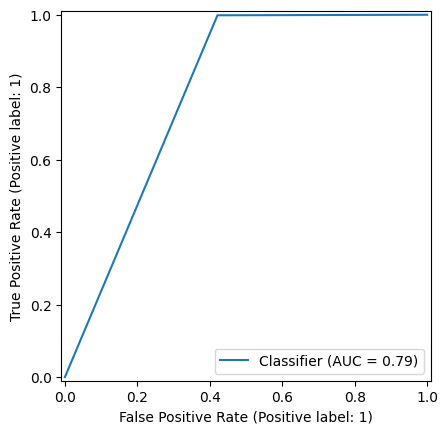

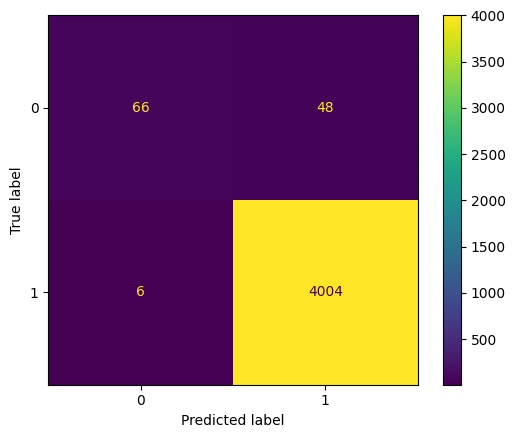

In [64]:
print("4. Tuned CatBoost IB\n")
evaluate(tuned_ib, DF_CATB_IB.iloc[:,1:101], DF_CATB_IB.iloc[:,0])

## 2. Check for model capabilities at a malware type level in each GBDT Models and each of its two behavior-types.

Using the `xx` dataset, determine the prediction capability of the model in each malware type.

**Answer this question:**

`How good are the model (as per classification report and confusion matrix) on a per-malware type basis?`

The theory is that malware-types that are prominent in terms of quantity might be detected accurately as malware than those that are not. 

### 2.1 Defining a helper function

In [65]:
def evaluate_per_type(model, test_set, mal_type):
    filtered_set = test_set.loc[(test_set['type'] == 'benign') | (test_set['type'] == mal_type)]
    y_pred = model.predict(filtered_set.iloc[:,1:101])
    acc = accuracy_score(filtered_set.iloc[:,0], y_pred)
    prec = precision_score(filtered_set.iloc[:,0], y_pred)
    rec = recall_score(filtered_set.iloc[:,0], y_pred)
    auc_roc = roc_auc_score(filtered_set.iloc[:,0], y_pred)
    f1 = f1_score(filtered_set.iloc[:,0], y_pred)
    cm = confusion_matrix(filtered_set.iloc[:,0], y_pred)
    print("Malware Type: " + mal_type)
    print("==========================")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc_roc:.4f}")
    print(f"TN: {cm[0,0]:4d} FN: {cm[1,0]:4d}")
    print(f"TP: {cm[1,1]:4d} FP: {cm[0,1]:4d}")
    print("")

### 2.1 LightGBM

In [66]:
#Load Verified Test/Holodut Dataset
DF_LGBM_TB = pd.read_csv('./Dataset/LGBM_TB_Test.csv', low_memory=False)
DF_LGBM_IB = pd.read_csv('./Dataset/LGBM_IB_Test.csv', low_memory=False)

# No need to drop these "_" muna, assume na walang false-labelled malicious samples (pa-comment out nalang muna).
# DF_LGBM_TB = DF_LGBM_TB[DF_LGBM_TB['type'] != '_']
# DF_LGBM_IB = DF_LGBM_IB[DF_LGBM_IB['type'] != '_']
DF_LGBM_TB = DF_LGBM_TB.dropna()
DF_LGBM_IB = DF_LGBM_IB.dropna()

#Models
default_tb = load('Models/LGBM/Default/RYZEN3b_LGBM_TB.model') # <== Point these to the respective .model files
default_ib = load('Models/LGBM/Default/RYZEN3b_LGBM_IB.model')
tuned_tb = load('Models/LGBM/Tuned/TUNED_Manual_RYZEN3b_LGBM_TB.model')
tuned_ib = load('Models/LGBM/Tuned/TUNED_Manual_RYZEN3b_LGBM_IB.model')

display(DF_LGBM_TB)
print("DF_LGBM_TB:", DF_LGBM_TB['type'].unique().tolist())
display(DF_LGBM_IB)
print("DF_LGBM_IB:", DF_LGBM_IB['type'].unique().tolist())

'''
COLUMNS:
Features = [:, 1:101]
Label = [:, 0]
Hash = [:, 101]
Type 1 (malware type) = [:, 102]
'''

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,208,172,240,117,240,262,112,123,65,...,274,215,274,215,274,215,274,215,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,215,274,158,215,274,158,215,172,117,...,15,240,117,240,117,240,117,172,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,82,240,117,240,117,240,117,240,117,...,208,93,208,16,31,215,108,208,24dd4677c14eb5828bda78749fded6b8,pua
4,1,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,cc5d38cb80faaf60d8efabecdc04f832,trojan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,1,82,240,117,240,117,93,117,16,147,...,230,240,117,225,35,208,89,225,5a99618b63178d7a221552fe962992e3,trojan
4120,1,112,274,158,215,274,158,215,298,76,...,117,76,172,117,286,172,117,275,45bf43151fd02d4ea1d1028386d12d06,trojan
4121,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,cf6242404774ee9d15c67c75c80e1a14,trojan
4122,1,82,240,117,240,117,240,117,240,117,...,215,208,297,93,303,264,187,208,6536fb7723a2a091fdd2610a36b32741,trojan


DF_LGBM_TB: ['trojan', 'pua', 'adware', 'downloader', 'hacktool', 'benign', 'worm', 'ransomware', 'miner', 'virus', 'spyware']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,208,172,240,117,262,112,123,65,274,...,307,307,307,307,307,307,307,307,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,215,274,158,172,117,198,208,260,257,...,307,307,307,307,307,307,307,307,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,82,240,117,93,16,228,208,198,86,...,307,307,307,307,307,307,307,307,24dd4677c14eb5828bda78749fded6b8,pua
4,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,cc5d38cb80faaf60d8efabecdc04f832,trojan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,1,82,240,117,93,16,147,228,208,71,...,307,307,307,307,307,307,307,307,5a99618b63178d7a221552fe962992e3,trojan
4120,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,45bf43151fd02d4ea1d1028386d12d06,trojan
4121,1,82,240,117,172,16,11,274,158,215,...,307,307,307,307,307,307,307,307,cf6242404774ee9d15c67c75c80e1a14,trojan
4122,1,82,240,117,16,297,93,303,264,215,...,307,307,307,307,307,307,307,307,6536fb7723a2a091fdd2610a36b32741,trojan


DF_LGBM_IB: ['trojan', 'pua', 'adware', 'downloader', 'hacktool', 'benign', 'worm', 'ransomware', 'miner', 'virus', 'spyware']


'\nCOLUMNS:\nFeatures = [:, 1:101]\nLabel = [:, 0]\nHash = [:, 101]\nType 1 (malware type) = [:, 102]\n'

In [67]:
print("1. Default LGBM TB\n")
for mal_type in DF_LGBM_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_tb, DF_LGBM_TB, mal_type)

1. Default LGBM TB

Malware Type: trojan
Accuracy:  0.9855
Precision: 0.9855
Recall:    0.9997
F1 Score:  0.9925
AUC-ROC:   0.7893
TN:   66 FN:    1
TP: 3258 FP:   48

Malware Type: pua
Accuracy:  0.8592
Precision: 0.8255
Recall:    1.0000
F1 Score:  0.9044
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:  227 FP:   48

Malware Type: adware
Accuracy:  0.8554
Precision: 0.8195
Recall:    1.0000
F1 Score:  0.9008
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:  218 FP:   48

Malware Type: downloader
Accuracy:  0.8674
Precision: 0.8378
Recall:    1.0000
F1 Score:  0.9118
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:  248 FP:   48

Malware Type: hacktool
Accuracy:  0.5862
Precision: 0.0400
Recall:    1.0000
F1 Score:  0.0769
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:    2 FP:   48

Malware Type: worm
Accuracy:  0.5826
Precision: 0.0204
Recall:    1.0000
F1 Score:  0.0400
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:    1 FP:   48

Malware Type: ransomware
Accuracy:  0.6735
Precision: 0.4074
Recall:    1.0000
F1 Score:  0

In [68]:
print("2. Default LGBM IB\n")
for mal_type in DF_LGBM_IB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_ib, DF_LGBM_IB, mal_type)

2. Default LGBM IB

Malware Type: trojan
Accuracy:  0.9846
Precision: 0.9861
Recall:    0.9982
F1 Score:  0.9921
AUC-ROC:   0.7973
TN:   68 FN:    6
TP: 3253 FP:   46

Malware Type: pua
Accuracy:  0.8651
Precision: 0.8315
Recall:    1.0000
F1 Score:  0.9080
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:  227 FP:   46

Malware Type: adware
Accuracy:  0.8614
Precision: 0.8258
Recall:    1.0000
F1 Score:  0.9046
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:  218 FP:   46

Malware Type: downloader
Accuracy:  0.8702
Precision: 0.8430
Recall:    0.9960
F1 Score:  0.9131
AUC-ROC:   0.7962
TN:   68 FN:    1
TP:  247 FP:   46

Malware Type: hacktool
Accuracy:  0.6034
Precision: 0.0417
Recall:    1.0000
F1 Score:  0.0800
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:    2 FP:   46

Malware Type: worm
Accuracy:  0.6000
Precision: 0.0213
Recall:    1.0000
F1 Score:  0.0417
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:    1 FP:   46

Malware Type: ransomware
Accuracy:  0.6871
Precision: 0.4177
Recall:    1.0000
F1 Score:  0

In [69]:
print("3. Tuned LGBM TB\n")
for mal_type in DF_LGBM_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_tb, DF_LGBM_TB, mal_type)

3. Tuned LGBM TB



Malware Type: trojan
Accuracy:  0.9861
Precision: 0.9861
Recall:    0.9997
F1 Score:  0.9928
AUC-ROC:   0.7981
TN:   68 FN:    1
TP: 3258 FP:   46

Malware Type: pua
Accuracy:  0.8651
Precision: 0.8315
Recall:    1.0000
F1 Score:  0.9080
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:  227 FP:   46

Malware Type: adware
Accuracy:  0.8614
Precision: 0.8258
Recall:    1.0000
F1 Score:  0.9046
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:  218 FP:   46

Malware Type: downloader
Accuracy:  0.8729
Precision: 0.8435
Recall:    1.0000
F1 Score:  0.9151
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:  248 FP:   46

Malware Type: hacktool
Accuracy:  0.6034
Precision: 0.0417
Recall:    1.0000
F1 Score:  0.0800
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:    2 FP:   46

Malware Type: worm
Accuracy:  0.6000
Precision: 0.0213
Recall:    1.0000
F1 Score:  0.0417
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:    1 FP:   46

Malware Type: ransomware
Accuracy:  0.6871
Precision: 0.4177
Recall:    1.0000
F1 Score:  0.5893
AUC-ROC:   0.7

In [70]:
print("4. Tuned LGBM IB\n")
for mal_type in DF_LGBM_IB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_ib, DF_LGBM_IB, mal_type)

4. Tuned LGBM IB

Malware Type: trojan
Accuracy:  0.9881
Precision: 0.9888
Recall:    0.9991
F1 Score:  0.9939
AUC-ROC:   0.8373
TN:   77 FN:    3
TP: 3256 FP:   37

Malware Type: pua
Accuracy:  0.8915
Precision: 0.8598
Recall:    1.0000
F1 Score:  0.9246
AUC-ROC:   0.8377
TN:   77 FN:    0
TP:  227 FP:   37

Malware Type: adware
Accuracy:  0.8886
Precision: 0.8549
Recall:    1.0000
F1 Score:  0.9218
AUC-ROC:   0.8377
TN:   77 FN:    0
TP:  218 FP:   37

Malware Type: downloader
Accuracy:  0.8950
Precision: 0.8697
Recall:    0.9960
F1 Score:  0.9286
AUC-ROC:   0.8357
TN:   77 FN:    1
TP:  247 FP:   37

Malware Type: hacktool
Accuracy:  0.6810
Precision: 0.0513
Recall:    1.0000
F1 Score:  0.0976
AUC-ROC:   0.8377
TN:   77 FN:    0
TP:    2 FP:   37

Malware Type: worm
Accuracy:  0.6783
Precision: 0.0263
Recall:    1.0000
F1 Score:  0.0513
AUC-ROC:   0.8377
TN:   77 FN:    0
TP:    1 FP:   37

Malware Type: ransomware
Accuracy:  0.7483
Precision: 0.4714
Recall:    1.0000
F1 Score:  0.6

### 2.2 CatBoost

In [71]:
#Load Verified Test/Holdout Dataset
DF_CATB_TB = pd.read_csv('./Dataset/CATB_TB_Test.csv', low_memory=False)
DF_CATB_IB = pd.read_csv('./Dataset/CATB_IB_Test.csv', low_memory=False)

# DF_CATB_TB = DF_CATB_TB[DF_CATB_TB['type'] != '_']
# DF_CATB_IB = DF_CATB_IB[DF_CATB_IB['type'] != '_']
DF_CATB_TB = DF_CATB_TB.dropna()
DF_CATB_IB = DF_CATB_IB.dropna(subset=['type']) # Drops na only on type column
DF_CATB_IB.iloc[:,1:101] = DF_CATB_IB.iloc[:,1:101].astype('str')
DF_CATB_IB.replace("nan", "NaN", inplace=True)

default_tb = catb.CatBoostClassifier()
default_ib = catb.CatBoostClassifier()
tuned_tb = catb.CatBoostClassifier()
tuned_ib = catb.CatBoostClassifier()
default_tb = default_tb.load_model("./Models/CATB/Default/RYZEN2b_CATB_TB.model", format='json')
default_ib = default_ib.load_model("./Models/CATB/Default/RYZEN2b_CATB_IB.model", format='json')
tuned_tb = tuned_tb.load_model("./Models/CATB/Tuned/TUNED_RYZEN2b_CATB_TB.model", format='json')
tuned_ib = tuned_ib.load_model("./Models/CATB/Tuned/TUNED_RYZEN2b_CATB_IB.model", format='json')

display(DF_CATB_TB)
print("DF_CATB_TB:", DF_CATB_TB['type'].unique().tolist())
display(DF_CATB_IB)
print("DF_CATB_IB:", DF_CATB_IB['type'].unique().tolist())

'''
COLUMNS:
Features = [:, 1:101]
Label = [:, 0]
Hash = [:, 101]
Type 1 (malware type) = [:, 102]
'''

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,NtAllocateVirtualMemory,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,NtQuerySystemInformation,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,...,NtOpenKey,NtClose,NtOpenKey,NtClose,NtOpenKey,NtClose,NtOpenKey,NtClose,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtAllocateVirtualMemory,GetFileType,NtAllocateVirtualMemory,SetUnhandledExceptionFilter,CoInitializeEx,NtClose,WSAStartup,NtAllocateVirtualMemory,24dd4677c14eb5828bda78749fded6b8,pua
4,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,cc5d38cb80faaf60d8efabecdc04f832,trojan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,GetFileType,LdrGetProcedureAddress,SetUnhandledExceptionFilter,FindWindowA,...,GetUserNameW,LdrLoadDll,LdrGetProcedureAddress,DrawTextExW,GetSystemMetrics,NtAllocateVirtualMemory,NtDuplicateObject,DrawTextExW,5a99618b63178d7a221552fe962992e3,trojan
4120,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,LdrGetProcedureAddress,LoadStringA,LdrGetDllHandle,LdrGetProcedureAddress,SetErrorMode,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemDirectoryW,45bf43151fd02d4ea1d1028386d12d06,trojan
4121,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,cf6242404774ee9d15c67c75c80e1a14,trojan
4122,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtAllocateVirtualMemory,NtCreateFile,GetFileType,SetFilePointerEx,NtReadFile,NtFreeVirtualMemory,NtAllocateVirtualMemory,6536fb7723a2a091fdd2610a36b32741,trojan


DF_CATB_TB: ['trojan', 'pua', 'adware', 'downloader', 'hacktool', 'benign', 'worm', 'ransomware', 'miner', 'virus', 'spyware']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,NtAllocateVirtualMemory,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtQuerySystemInformation,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,NtOpenKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,GetFileType,SetUnhandledExceptionFilter,NtProtectVirtualMemory,NtAllocateVirtualMemory,GetSystemInfo,NtCreateMutant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24dd4677c14eb5828bda78749fded6b8,pua
4,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cc5d38cb80faaf60d8efabecdc04f832,trojan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,GetFileType,SetUnhandledExceptionFilter,FindWindowA,NtProtectVirtualMemory,NtAllocateVirtualMemory,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a99618b63178d7a221552fe962992e3,trojan
4120,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45bf43151fd02d4ea1d1028386d12d06,trojan
4121,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cf6242404774ee9d15c67c75c80e1a14,trojan
4122,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,SetUnhandledExceptionFilter,NtCreateFile,GetFileType,SetFilePointerEx,NtReadFile,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6536fb7723a2a091fdd2610a36b32741,trojan


DF_CATB_IB: ['trojan', 'pua', 'adware', 'downloader', 'hacktool', 'benign', 'worm', 'ransomware', 'miner', 'virus', 'spyware']


'\nCOLUMNS:\nFeatures = [:, 1:101]\nLabel = [:, 0]\nHash = [:, 101]\nType 1 (malware type) = [:, 102]\n'

In [72]:
print("1. Default CatBoost TB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_tb, DF_CATB_TB, mal_type)

1. Default CatBoost TB

Malware Type: trojan
Accuracy:  0.9852
Precision: 0.9858
Recall:    0.9991
F1 Score:  0.9924
AUC-ROC:   0.7934
TN:   67 FN:    3
TP: 3256 FP:   47

Malware Type: pua
Accuracy:  0.8622
Precision: 0.8285
Recall:    1.0000
F1 Score:  0.9062
AUC-ROC:   0.7939
TN:   67 FN:    0
TP:  227 FP:   47

Malware Type: adware
Accuracy:  0.8584
Precision: 0.8226
Recall:    1.0000
F1 Score:  0.9027
AUC-ROC:   0.7939
TN:   67 FN:    0
TP:  218 FP:   47

Malware Type: downloader
Accuracy:  0.8702
Precision: 0.8407
Recall:    1.0000
F1 Score:  0.9134
AUC-ROC:   0.7939
TN:   67 FN:    0
TP:  248 FP:   47

Malware Type: hacktool
Accuracy:  0.5948
Precision: 0.0408
Recall:    1.0000
F1 Score:  0.0784
AUC-ROC:   0.7939
TN:   67 FN:    0
TP:    2 FP:   47

Malware Type: worm
Accuracy:  0.5913
Precision: 0.0208
Recall:    1.0000
F1 Score:  0.0408
AUC-ROC:   0.7939
TN:   67 FN:    0
TP:    1 FP:   47

Malware Type: ransomware
Accuracy:  0.6803
Precision: 0.4125
Recall:    1.0000
F1 Score

In [73]:
print("2. Default CatBoost IB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_ib, DF_CATB_IB, mal_type)

2. Default CatBoost IB

Malware Type: trojan
Accuracy:  0.9867
Precision: 0.9873
Recall:    0.9991
F1 Score:  0.9931
AUC-ROC:   0.8153
TN:   72 FN:    3
TP: 3256 FP:   42

Malware Type: pua
Accuracy:  0.8768
Precision: 0.8439
Recall:    1.0000
F1 Score:  0.9153
AUC-ROC:   0.8158
TN:   72 FN:    0
TP:  227 FP:   42

Malware Type: adware
Accuracy:  0.8705
Precision: 0.8378
Recall:    0.9954
F1 Score:  0.9099
AUC-ROC:   0.8135
TN:   72 FN:    1
TP:  217 FP:   42

Malware Type: downloader
Accuracy:  0.8812
Precision: 0.8547
Recall:    0.9960
F1 Score:  0.9199
AUC-ROC:   0.8138
TN:   72 FN:    1
TP:  247 FP:   42

Malware Type: hacktool
Accuracy:  0.6379
Precision: 0.0455
Recall:    1.0000
F1 Score:  0.0870
AUC-ROC:   0.8158
TN:   72 FN:    0
TP:    2 FP:   42

Malware Type: worm
Accuracy:  0.6348
Precision: 0.0233
Recall:    1.0000
F1 Score:  0.0455
AUC-ROC:   0.8158
TN:   72 FN:    0
TP:    1 FP:   42

Malware Type: ransomware
Accuracy:  0.7143
Precision: 0.4400
Recall:    1.0000
F1 Score

In [74]:
print("3. Tuned CatBoost TB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_tb, DF_CATB_TB, mal_type)

3. Tuned CatBoost TB

Malware Type: trojan
Accuracy:  0.9849
Precision: 0.9861
Recall:    0.9985
F1 Score:  0.9922
AUC-ROC:   0.7975
TN:   68 FN:    5
TP: 3254 FP:   46

Malware Type: pua
Accuracy:  0.8651
Precision: 0.8315
Recall:    1.0000
F1 Score:  0.9080
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:  227 FP:   46

Malware Type: adware
Accuracy:  0.8614
Precision: 0.8258
Recall:    1.0000
F1 Score:  0.9046
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:  218 FP:   46

Malware Type: downloader
Accuracy:  0.8729
Precision: 0.8435
Recall:    1.0000
F1 Score:  0.9151
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:  248 FP:   46

Malware Type: hacktool
Accuracy:  0.6034
Precision: 0.0417
Recall:    1.0000
F1 Score:  0.0800
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:    2 FP:   46

Malware Type: worm
Accuracy:  0.6000
Precision: 0.0213
Recall:    1.0000
F1 Score:  0.0417
AUC-ROC:   0.7982
TN:   68 FN:    0
TP:    1 FP:   46

Malware Type: ransomware
Accuracy:  0.6871
Precision: 0.4177
Recall:    1.0000
F1 Score: 

In [75]:
print("4. Tuned CatBoost IB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_ib, DF_CATB_IB, mal_type)

4. Tuned CatBoost IB

Malware Type: trojan
Accuracy:  0.9840
Precision: 0.9855
Recall:    0.9982
F1 Score:  0.9918
AUC-ROC:   0.7886
TN:   66 FN:    6
TP: 3253 FP:   48

Malware Type: pua
Accuracy:  0.8592
Precision: 0.8255
Recall:    1.0000
F1 Score:  0.9044
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:  227 FP:   48

Malware Type: adware
Accuracy:  0.8554
Precision: 0.8195
Recall:    1.0000
F1 Score:  0.9008
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:  218 FP:   48

Malware Type: downloader
Accuracy:  0.8674
Precision: 0.8378
Recall:    1.0000
F1 Score:  0.9118
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:  248 FP:   48

Malware Type: hacktool
Accuracy:  0.5862
Precision: 0.0400
Recall:    1.0000
F1 Score:  0.0769
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:    2 FP:   48

Malware Type: worm
Accuracy:  0.5826
Precision: 0.0204
Recall:    1.0000
F1 Score:  0.0400
AUC-ROC:   0.7895
TN:   66 FN:    0
TP:    1 FP:   48

Malware Type: ransomware
Accuracy:  0.6735
Precision: 0.4074
Recall:    1.0000
F1 Score: 